# Bengali Hate Speech Detection - BERT Training on Kaggle

**Objective:** Fine-tune Bengali BERT for multi-label hate speech classification

**Dataset:** Multi-labeled toxic comments (16,068 samples)
**Labels:** vulgar, hate, religious, threat, troll, Insult
**Model:** sagorsarker/bangla-bert-base
**Target:** Beat baseline SVM F1-score

**Hardware:** Kaggle GPU (Tesla P100)

In [2]:
# Don't install packages, use what's available on Kaggle
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    TrainingArguments, 
    Trainer
)
from sklearn.metrics import classification_report, f1_score, accuracy_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# The warnings you see are normal - GPU is working fine!
print(f"✅ PyTorch version: {torch.__version__}")
print(f"✅ CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✅ Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

print("\n🚀 Ready for training!")

✅ PyTorch version: 2.6.0+cu124
✅ CUDA available: True
✅ GPU: Tesla P100-PCIE-16GB
✅ Memory: 17.1 GB

🚀 Ready for training!


In [3]:
# Check available datasets
import os
print("Available input datasets:")
for item in os.listdir('/kaggle/input'):
    print(f"  - {item}")

# Update the path below based on what you see
# It should be something like '/kaggle/input/bengali-hate-speech-data/'

Available input datasets:
  - hate-dataset


In [4]:
# Load preprocessed data
# Note: Upload your train_dataset1.csv and val_dataset1.csv to Kaggle dataset first

train_df = pd.read_csv('/kaggle/input/hate-dataset/train_dataset1.csv')
val_df = pd.read_csv('/kaggle/input/hate-dataset/val_dataset1.csv')

print(f"Training set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")

# Define labels
label_columns = ['vulgar', 'hate', 'religious', 'threat', 'troll', 'Insult']
print(f"Labels: {label_columns}")

# Quick data check
print(f"\nSample text: {train_df['text'].iloc[0]}")
print(f"Sample labels: {train_df[label_columns].iloc[0].tolist()}")

Training set: 11253 samples
Validation set: 2404 samples
Labels: ['vulgar', 'hate', 'religious', 'threat', 'troll', 'Insult']

Sample text: এবার পাগলামি বন্ধ করো আর কত।
Sample labels: [0, 0, 0, 0, 0, 1]


In [5]:
class BengaliHateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        
        # Tokenize
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        # Get labels
        labels = torch.FloatTensor(self.labels.iloc[idx].values)
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': labels
        }

print("Dataset class defined")

Dataset class defined


In [7]:
# Load Bengali BERT tokenizer and model
model_name = "sagorsarker/bangla-bert-base"

print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_name)

print("Loading model...")
# Create model for multi-label classification
num_labels = len(label_columns)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    problem_type="multi_label_classification"
)

print(f"✅ Model: {model_name}")
print(f"✅ Tokenizer vocab size: {tokenizer.vocab_size}")
print(f"✅ Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Test tokenization
sample_text = train_df['text'].iloc[0]
tokens = tokenizer.tokenize(sample_text)
print(f"\n✅ Sample tokenization:")
print(f"Text: {sample_text}")
print(f"Tokens ({len(tokens)}): {tokens[:15]}")

print(f"\n✅ Tokenizer is ready!")

Loading tokenizer...


config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

Loading model...


model.safetensors:   0%|          | 0.00/660M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model: sagorsarker/bangla-bert-base
✅ Tokenizer vocab size: 101975
✅ Model parameters: 164,401,158

✅ Sample tokenization:
Text: এবার পাগলামি বন্ধ করো আর কত।
Tokens (8): ['এবার', 'পাগলামি', 'বনধ', 'করে', '##া', 'আর', 'কত', '।']

✅ Tokenizer is ready!


In [8]:
# Create datasets
train_dataset = BengaliHateSpeechDataset(
    train_df['text'], 
    train_df[label_columns], 
    tokenizer,
    max_length=256
)

val_dataset = BengaliHateSpeechDataset(
    val_df['text'],
    val_df[label_columns], 
    tokenizer,
    max_length=256
)

print(f"✅ Train dataset: {len(train_dataset)} samples")
print(f"✅ Val dataset: {len(val_dataset)} samples")

# Test dataset
sample = train_dataset[0]
print(f"\n✅ Sample data shapes:")
for key, value in sample.items():
    print(f"  {key}: {value.shape}")

print(f"\n✅ Datasets ready for training!")

✅ Train dataset: 11253 samples
✅ Val dataset: 2404 samples

✅ Sample data shapes:
  input_ids: torch.Size([256])
  attention_mask: torch.Size([256])
  labels: torch.Size([6])

✅ Datasets ready for training!


In [14]:
# Training configuration (without wandb)
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=200,
    eval_strategy="steps",
    eval_steps=1000,
    save_strategy="steps", 
    save_steps=2000,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,
    remove_unused_columns=False,
    dataloader_pin_memory=False,
    fp16=True,
    report_to="none",  # Disable wandb logging
    disable_tqdm=False,  # Keep progress bars
)

print("✅ Training arguments configured (wandb disabled)")
print(f"Batch size: {training_args.per_device_train_batch_size}")
print(f"Epochs: {training_args.num_train_epochs}")
print(f"Mixed precision: {training_args.fp16}")
print(f"Logging: {training_args.report_to}")

✅ Training arguments configured (wandb disabled)
Batch size: 8
Epochs: 3
Mixed precision: True
Logging: []


In [15]:
def compute_metrics(eval_pred):
    """Compute metrics for multi-label classification"""
    predictions, labels = eval_pred
    
    # Apply sigmoid to get probabilities
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    
    # Convert to binary predictions (threshold = 0.5)
    y_pred = (probs > 0.5).int().numpy()
    y_true = labels.astype(int)
    
    # Calculate metrics
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    
    # Per-label F1 scores
    f1_per_label = f1_score(y_true, y_pred, average=None, zero_division=0)
    
    results = {
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
        'accuracy': accuracy,
    }
    
    # Add per-label F1 scores
    for i, label in enumerate(label_columns):
        results[f'f1_{label}'] = f1_per_label[i]
    
    return results

print("Metrics function defined")

Metrics function defined


In [16]:
# Create trainer (recreate with new args)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

print("✅ Trainer created (without wandb)")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Steps per epoch: {len(train_dataset) // training_args.per_device_train_batch_size}")

✅ Trainer created (without wandb)
Training samples: 11253
Validation samples: 2404
Steps per epoch: 1406


In [17]:
# Start training
print("🚀 Starting BERT training...")

# Train the model
trainer.train()

print("✅ Training completed!")

# Save the final model
trainer.save_model("./bengali-hate-speech-bert")
tokenizer.save_pretrained("./bengali-hate-speech-bert")

print("✅ Model saved to ./bengali-hate-speech-bert")

🚀 Starting BERT training...


Step,Training Loss,Validation Loss,F1 Macro,F1 Micro,Accuracy,F1 Vulgar,F1 Hate,F1 Religious,F1 Threat,F1 Troll,F1 Insult
1000,0.227300,0.219887,0.545006,0.594179,0.626872,0.753442,0.364116,0.728571,0.520958,0.273616,0.629333
2000,0.166500,0.197857,0.638742,0.665224,0.697587,0.786458,0.618785,0.792541,0.638393,0.345048,0.651226
3000,0.107700,0.200820,0.663057,0.682143,0.704243,0.798913,0.621974,0.826840,0.641834,0.409449,0.679330
4000,0.092000,0.201550,0.682476,0.693793,0.717554,0.801630,0.621572,0.790909,0.718072,0.461176,0.701493


✅ Training completed!
The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupted !
✅ Model saved to ./bengali-hate-speech-bert


In [18]:
# Evaluate on validation set
print("Evaluating model...")

# Get predictions
eval_results = trainer.evaluate()

print("Validation Results:")
print("=" * 40)
for key, value in eval_results.items():
    if key.startswith('eval_'):
        metric_name = key.replace('eval_', '')
        print(f"{metric_name}: {value:.4f}")

# Get detailed predictions for analysis
predictions = trainer.predict(val_dataset)
y_pred_probs = torch.sigmoid(torch.tensor(predictions.predictions))
y_pred = (y_pred_probs > 0.5).int().numpy()
y_true = predictions.label_ids.astype(int)

print(f"\nDetailed Performance:")
print("=" * 50)

# Overall metrics
accuracy = accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)

print(f"Exact Match Accuracy: {accuracy:.4f}")
print(f"Macro F1-score: {f1_macro:.4f}")
print(f"Micro F1-score: {f1_micro:.4f}")

# Per-label performance
print(f"\nPer-label Results:")
f1_per_label = f1_score(y_true, y_pred, average=None, zero_division=0)
for i, (label, f1) in enumerate(zip(label_columns, f1_per_label)):
    support = y_true[:, i].sum()
    print(f"  {label:12s}: F1={f1:.3f} (Support: {support})")

Evaluating model...


Validation Results:
loss: 0.2016
f1_macro: 0.6825
f1_micro: 0.6938
accuracy: 0.7176
f1_vulgar: 0.8016
f1_hate: 0.6216
f1_religious: 0.7909
f1_threat: 0.7181
f1_troll: 0.4612
f1_Insult: 0.7015
runtime: 19.0502
samples_per_second: 126.1930
steps_per_second: 15.8000

Detailed Performance:
Exact Match Accuracy: 0.7176
Macro F1-score: 0.6825
Micro F1-score: 0.6938

Per-label Results:
  vulgar      : F1=0.802 (Support: 386)
  hate        : F1=0.622 (Support: 280)
  religious   : F1=0.791 (Support: 225)
  threat      : F1=0.718 (Support: 214)
  troll       : F1=0.461 (Support: 218)
  Insult      : F1=0.701 (Support: 413)


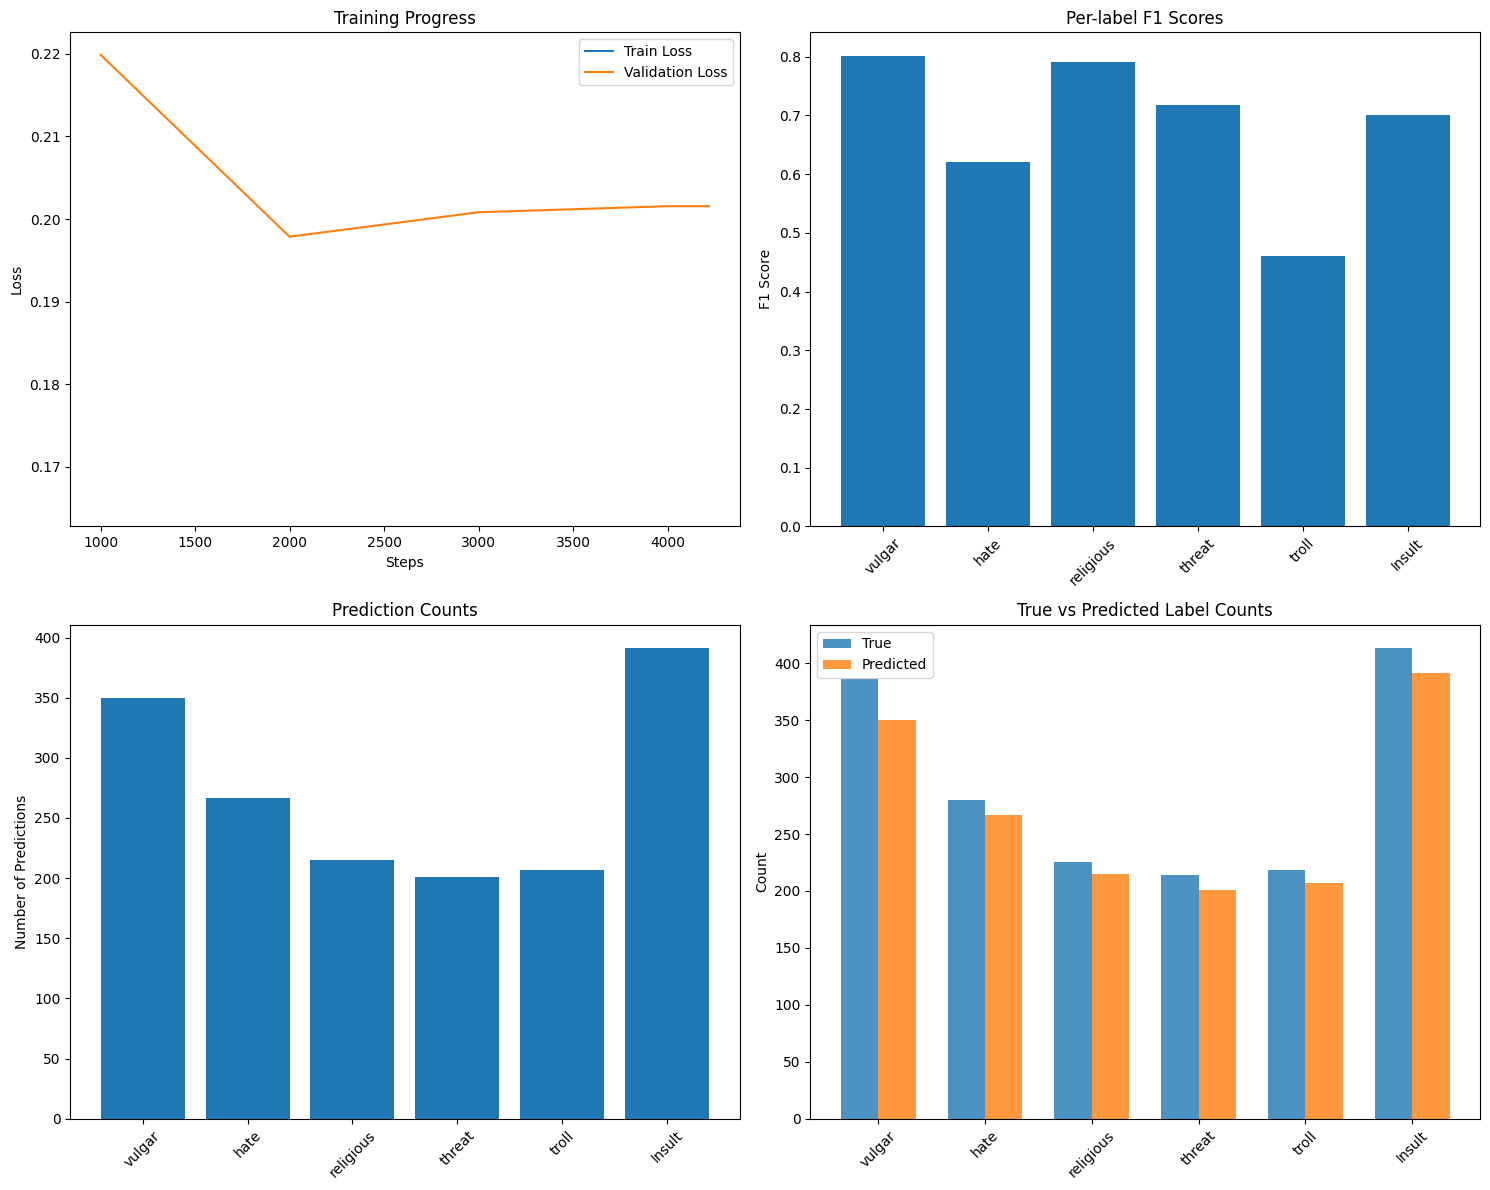


🎯 FINAL RESULTS SUMMARY
Model: sagorsarker/bangla-bert-base
Training samples: 11,253
Validation samples: 2,404
Exact Match Accuracy: 0.7176
Macro F1-score: 0.6825
Micro F1-score: 0.6938
Best label: vulgar (F1: 0.802)
Worst label: troll (F1: 0.461)


In [19]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Training history (if available)
if hasattr(trainer.state, 'log_history'):
    logs = trainer.state.log_history
    train_loss = [log['train_loss'] for log in logs if 'train_loss' in log]
    eval_loss = [log['eval_loss'] for log in logs if 'eval_loss' in log]
    
    steps_train = [log['step'] for log in logs if 'train_loss' in log]
    steps_eval = [log['step'] for log in logs if 'eval_loss' in log]
    
    axes[0,0].plot(steps_train, train_loss, label='Train Loss')
    axes[0,0].plot(steps_eval, eval_loss, label='Validation Loss')
    axes[0,0].set_title('Training Progress')
    axes[0,0].set_xlabel('Steps')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()

# 2. Per-label F1 scores
axes[0,1].bar(label_columns, f1_per_label)
axes[0,1].set_title('Per-label F1 Scores')
axes[0,1].set_ylabel('F1 Score')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Prediction distribution
pred_counts = y_pred.sum(axis=0)
axes[1,0].bar(label_columns, pred_counts)
axes[1,0].set_title('Prediction Counts')
axes[1,0].set_ylabel('Number of Predictions')
axes[1,0].tick_params(axis='x', rotation=45)

# 4. True vs Predicted comparison
true_counts = y_true.sum(axis=0)
x = np.arange(len(label_columns))
width = 0.35

axes[1,1].bar(x - width/2, true_counts, width, label='True', alpha=0.8)
axes[1,1].bar(x + width/2, pred_counts, width, label='Predicted', alpha=0.8)
axes[1,1].set_title('True vs Predicted Label Counts')
axes[1,1].set_ylabel('Count')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(label_columns)
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].legend()

plt.tight_layout()
plt.show()

# Final summary
print(f"\n🎯 FINAL RESULTS SUMMARY")
print(f"=" * 50)
print(f"Model: {model_name}")
print(f"Training samples: {len(train_dataset):,}")
print(f"Validation samples: {len(val_dataset):,}")
print(f"Exact Match Accuracy: {accuracy:.4f}")
print(f"Macro F1-score: {f1_macro:.4f}")
print(f"Micro F1-score: {f1_micro:.4f}")
print(f"Best label: {label_columns[np.argmax(f1_per_label)]} (F1: {np.max(f1_per_label):.3f})")
print(f"Worst label: {label_columns[np.argmin(f1_per_label)]} (F1: {np.min(f1_per_label):.3f})")

In [20]:
# Load test set and evaluate
test_df = pd.read_csv('/kaggle/input/bert-test/test_dataset1.csv')

test_dataset = BengaliHateSpeechDataset(
    test_df['text'],
    test_df[label_columns], 
    tokenizer,
    max_length=256
)

print(f"Test set: {len(test_dataset)} samples")

# Final evaluation
test_results = trainer.evaluate(test_dataset)
print("Final Test Results:")
for key, value in test_results.items():
    if key.startswith('eval_'):
        print(f"{key.replace('eval_', '')}: {value:.4f}")

# Get test predictions for baseline comparison
test_predictions = trainer.predict(test_dataset)
test_probs = torch.sigmoid(torch.tensor(test_predictions.predictions))
test_pred = (test_probs > 0.5).int().numpy()
test_true = test_predictions.label_ids.astype(int)

test_f1 = f1_score(test_true, test_pred, average='macro', zero_division=0)
print(f"\nFinal Test F1-score: {test_f1:.4f}")

Test set: 2411 samples


Final Test Results:
loss: 0.2019
f1_macro: 0.6749
f1_micro: 0.6791
accuracy: 0.7084
f1_vulgar: 0.8203
f1_hate: 0.6081
f1_religious: 0.7769
f1_threat: 0.6853
f1_troll: 0.4866
f1_Insult: 0.6725
runtime: 19.0754
samples_per_second: 126.3930
steps_per_second: 15.8320

Final Test F1-score: 0.6749


In [21]:
# Check if more training would help
print("Training Loss Progression:")
logs = trainer.state.log_history
train_losses = [log['train_loss'] for log in logs if 'train_loss' in log]
eval_losses = [log['eval_loss'] for log in logs if 'eval_loss' in log]

print("Train losses:", train_losses[-3:])  # Last 3 train losses
print("Eval losses:", eval_losses[-3:])   # Last 3 eval losses

if eval_losses[-1] > eval_losses[-2]:
    print("⚠️  Validation loss increasing - overfitting risk")
else:
    print("✅ Validation loss still decreasing - room for improvement")

Training Loss Progression:
Train losses: [0.1655132456487797]
Eval losses: [0.2015504688024521, 0.2015504688024521, 0.20190736651420593]
⚠️  Validation loss increasing - overfitting risk
